In [1]:
pip install lime

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score
)

import shap
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

In [3]:
dt = pd.read_csv("Dataset.csv").drop(columns=['Unnamed: 0', 'Id'])
dt2 = pd.read_csv("Dataset2.csv")

In [4]:
dt = dt.replace([np.inf, -np.inf], np.nan)
dt = dt.applymap(lambda x: np.nan if isinstance(x, (int, float)) and abs(x) > 1e10 else x)
dt = dt.dropna()

In [5]:
y_reg = dt['price']
X_reg = dt.drop(columns=['price'])

y_clf = dt2['profile_id']
X_clf = dt2.drop(columns=['profile_id'])

# Пайплайн

In [6]:
def create_pipeline(model, X):
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    num_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols)
    ], remainder='drop')

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    return pipeline

In [7]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

## Регрессионные модели

In [8]:
reg_models = {
    'LinearRegression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'RandomForest': RandomForestRegressor(),
    'DecisionTree': DecisionTreeRegressor()
}

reg_results = []
for name, model in reg_models.items():
    pipe = create_pipeline(model, X_reg_train)
    pipe.fit(X_reg_train, y_reg_train)
    preds = pipe.predict(X_reg_test)

    mse = mean_squared_error(y_reg_test, preds)
    mae = mean_absolute_error(y_reg_test, preds)
    rmse = np.sqrt(mse)

    reg_results.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    })

reg_df_results = pd.DataFrame(reg_results)
print(reg_df_results)

              Model           MSE            MAE          RMSE
0  LinearRegression  1.866341e+12  803823.248234  1.366141e+06
1               KNN  8.426244e+11  347790.909091  9.179458e+05
2      RandomForest  5.733516e+09   10850.161290  7.571999e+04
3      DecisionTree  1.380769e+10   13211.143695  1.175061e+05


# Классификационные модели

In [9]:
X_clf_train_sample = X_clf_train.sample(n=5000, random_state=42)
y_clf_train_sample = y_clf_train.loc[X_clf_train_sample.index]

clf_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, n_jobs=-1),
    'GaussianNB': GaussianNB(),
    'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

clf_results = []
for name, model in clf_models.items():
    print(f"Обучаю модель: {name}")
    pipe = create_pipeline(model, X_clf_train_sample)
    pipe.fit(X_clf_train_sample, y_clf_train_sample)
    preds = pipe.predict(X_clf_test)

    acc = accuracy_score(y_clf_test, preds)
    prec = precision_score(y_clf_test, preds, average='macro', zero_division=0)
    rec = recall_score(y_clf_test, preds, average='macro', zero_division=0)
    f1 = f1_score(y_clf_test, preds, average='macro', zero_division=0)

    clf_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

Обучаю модель: LogisticRegression
Обучаю модель: GaussianNB
Обучаю модель: RandomForest
Обучаю модель: DecisionTree


In [10]:
clf_df_results = pd.DataFrame(clf_results)
print("\n Результаты классификационных моделей (уменьшенная выборка):")
print(clf_df_results)


 Результаты классификационных моделей (уменьшенная выборка):
                Model  Accuracy  Precision    Recall  F1-Score
0  LogisticRegression  0.367165   0.348859  0.319842  0.299146
1          GaussianNB  0.435780   0.417401  0.457190  0.409336
2        RandomForest  0.467047   0.527240  0.392378  0.366348
3        DecisionTree  0.283671   0.171476  0.221795  0.157962


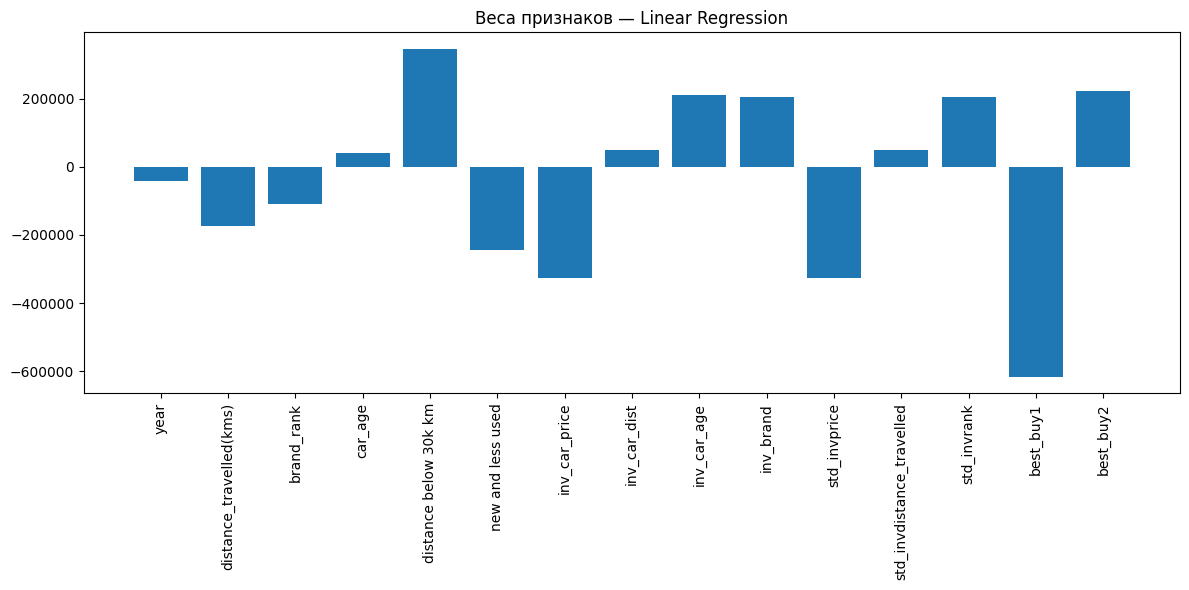

In [11]:
lin_pipe = create_pipeline(LinearRegression(), X_reg_train)
lin_pipe.fit(X_reg_train, y_reg_train)
numeric_cols = X_reg_train.select_dtypes(include=np.number).columns
weights = lin_pipe.named_steps['model'].coef_

plt.figure(figsize=(12, 6))
plt.bar(numeric_cols, weights)
plt.title("Веса признаков — Linear Regression")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

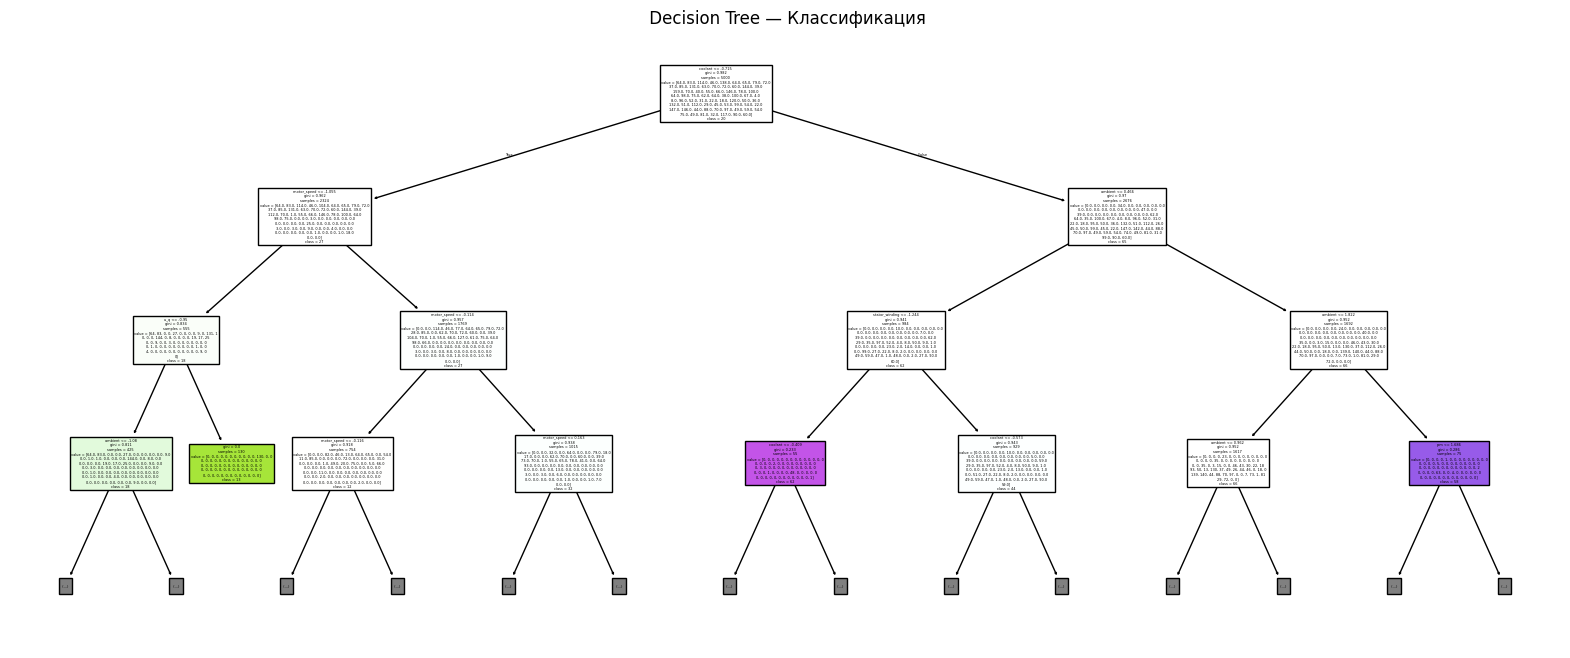

In [12]:
tree_pipe = create_pipeline(DecisionTreeClassifier(max_depth=5, random_state=42), X_clf_train_sample)
tree_pipe.fit(X_clf_train_sample, y_clf_train_sample)

plt.figure(figsize=(20, 8))
plot_tree(
    tree_pipe.named_steps['model'],
    feature_names=X_clf_train_sample.columns,
    class_names=[str(c) for c in np.unique(y_clf_train_sample)],
    filled=True,
    max_depth=3
)
plt.title(" Decision Tree — Классификация")
plt.show()

SHAP анализ

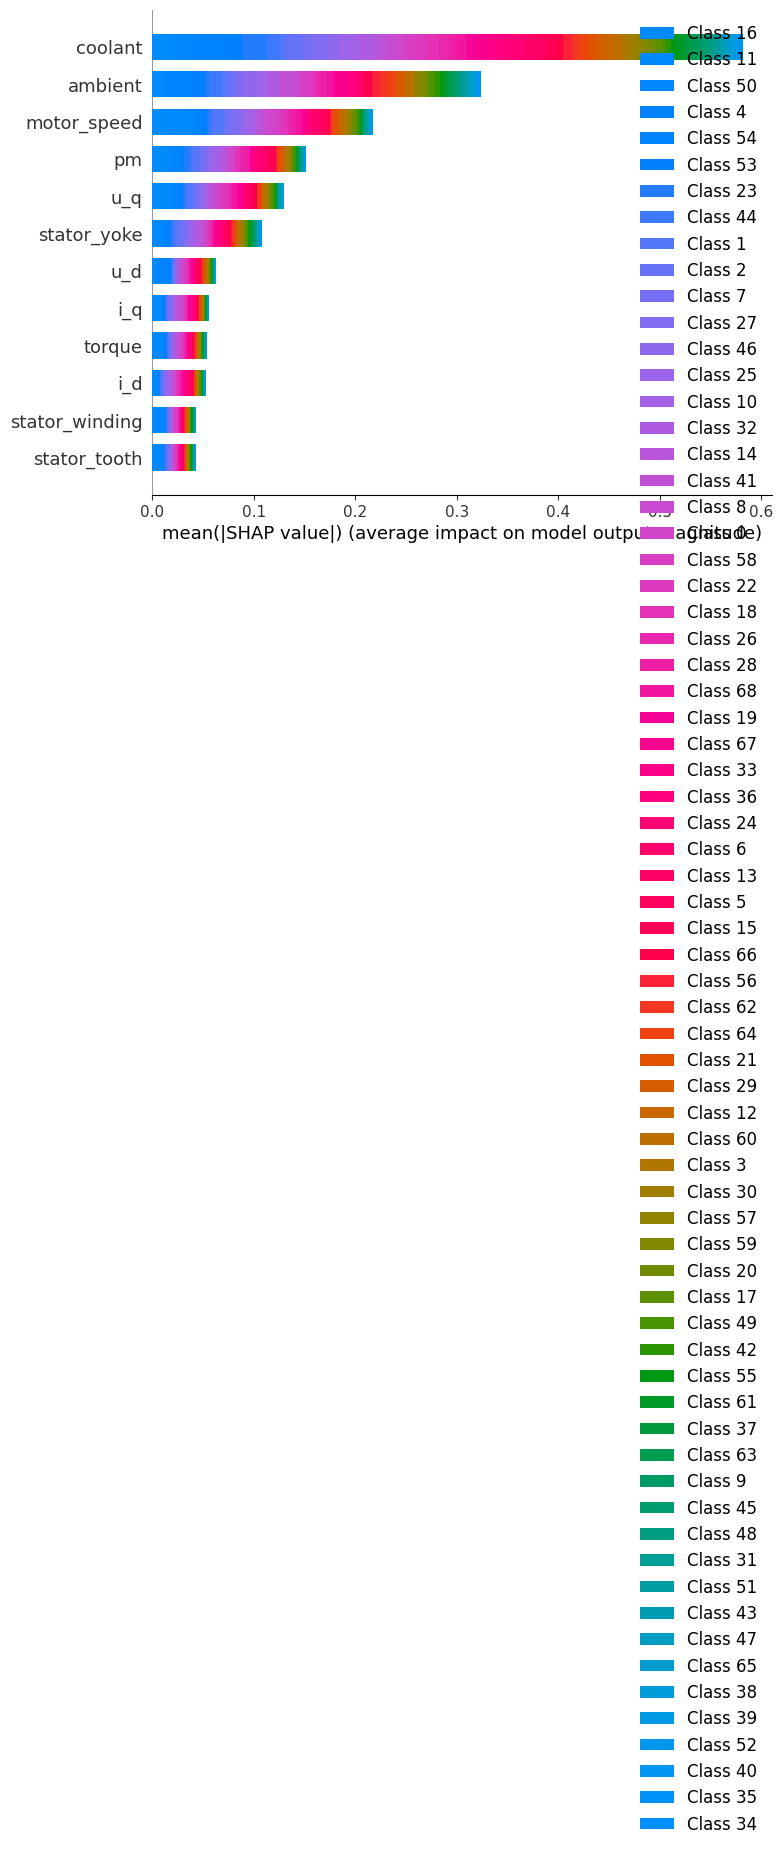

Проблемы с SHAP: index 16 is out of bounds for axis 1 with size 12


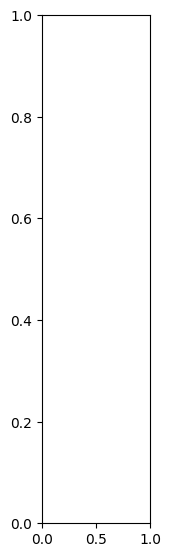

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif


try:
    sample_size = 5000
    k_features = 30
    X_clf_train_sample = X_clf_train.sample(n=sample_size, random_state=42)
    y_clf_train_sample = y_clf_train.loc[X_clf_train_sample.index]

    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_clf_train_selected = selector.fit_transform(X_clf_train_sample, y_clf_train_sample)
    X_clf_test_selected = selector.transform(X_clf_test)

    selected_features = X_clf.columns[selector.get_support()]

    model = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
    model.fit(X_clf_train_selected, y_clf_train_sample)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_clf_test_selected)

    shap.summary_plot(shap_values, features=X_clf_test_selected, feature_names=selected_features, plot_type="bar")
    shap.summary_plot(shap_values, features=X_clf_test_selected, feature_names=selected_features)

except Exception as e:
    print(f"Проблемы с SHAP: {e}")

 LIME

In [14]:



reg_pipe = create_pipeline(RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42), X_reg_train)
reg_pipe.fit(X_reg_train, y_reg_train)
reg_preds = reg_pipe.predict(X_reg_test)
diffs = np.abs(reg_preds - y_reg_test.values)
worst_idx = np.argmax(diffs)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=reg_pipe.named_steps['preprocessing'].transform(X_reg_train),
    feature_names=X_reg_train.select_dtypes(include=np.number).columns.tolist(),
    mode='regression'
)

exp = lime_explainer.explain_instance(
    reg_pipe.named_steps['preprocessing'].transform(X_reg_test)[worst_idx],
    reg_pipe.named_steps['model'].predict,
    num_features=10
)
exp.show_in_notebook()


In [15]:
print("\n Выводы по регрессионным моделям:")
best_reg = reg_df_results.sort_values(by='RMSE').iloc[0]
print(f"Лучшая модель: {best_reg['Model']} с RMSE = {best_reg['RMSE']:.2f}")

print("\n Выводы по классификационным моделям:")
best_clf = clf_df_results.sort_values(by='F1-Score', ascending=False).iloc[0]
print(f"Лучшая модель: {best_clf['Model']} с F1-Score = {best_clf['F1-Score']:.2f}")

print("\n SHAP-графики показывают важнейшие признаки по убыванию влияния. \nBarplot — общая важность, Beeswarm — распределение влияния, Waterfall — детализация для одного примера, Force — визуальный вклад фичи в прогноз.")

print("\n LIME показал, какие признаки привели к наибольшей ошибке прогноза по конкретному примеру. Возможно, модель не учла важный признак или переоценила незначительный.")



 Выводы по регрессионным моделям:
Лучшая модель: RandomForest с RMSE = 75719.99

 Выводы по классификационным моделям:
Лучшая модель: GaussianNB с F1-Score = 0.41

 SHAP-графики показывают важнейшие признаки по убыванию влияния. 
Barplot — общая важность, Beeswarm — распределение влияния, Waterfall — детализация для одного примера, Force — визуальный вклад фичи в прогноз.

 LIME показал, какие признаки привели к наибольшей ошибке прогноза по конкретному примеру. Возможно, модель не учла важный признак или переоценила незначительный.
